**Name**: Anirudh Rao

**Roll No.**: BE21B004



---



In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We create the dataset using `sklearn`'s `make_circles` function. We replace the label $0$ with $-1$ to make the AdaBoost implementation mathematically convenient.

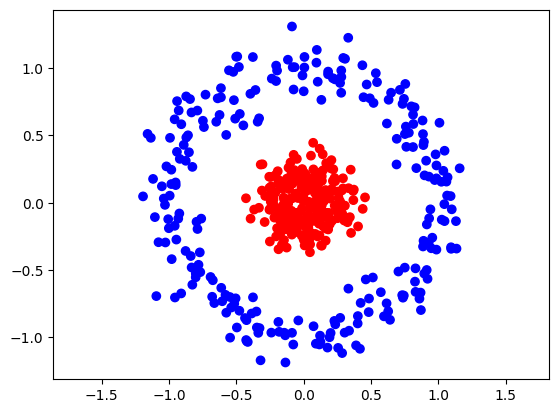

In [2]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors

X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=colors.ListedColormap(['blue', 'red']))
plt.axis('equal')
plt.show()

# Task 1

In [3]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score

We define the AdaBoost classifier using the algorithm given in the question. To incorporate the hyperparameter $\eta$, we modify the weight update rule to be $w_{i,t+1}=w_{i,t}\exp(-\eta y_{i}\alpha_{t}h_{t}(x))$. This controls how the weights are updated. We also define a function to plot the decision boundaries of the individual estimators and the ensemble.

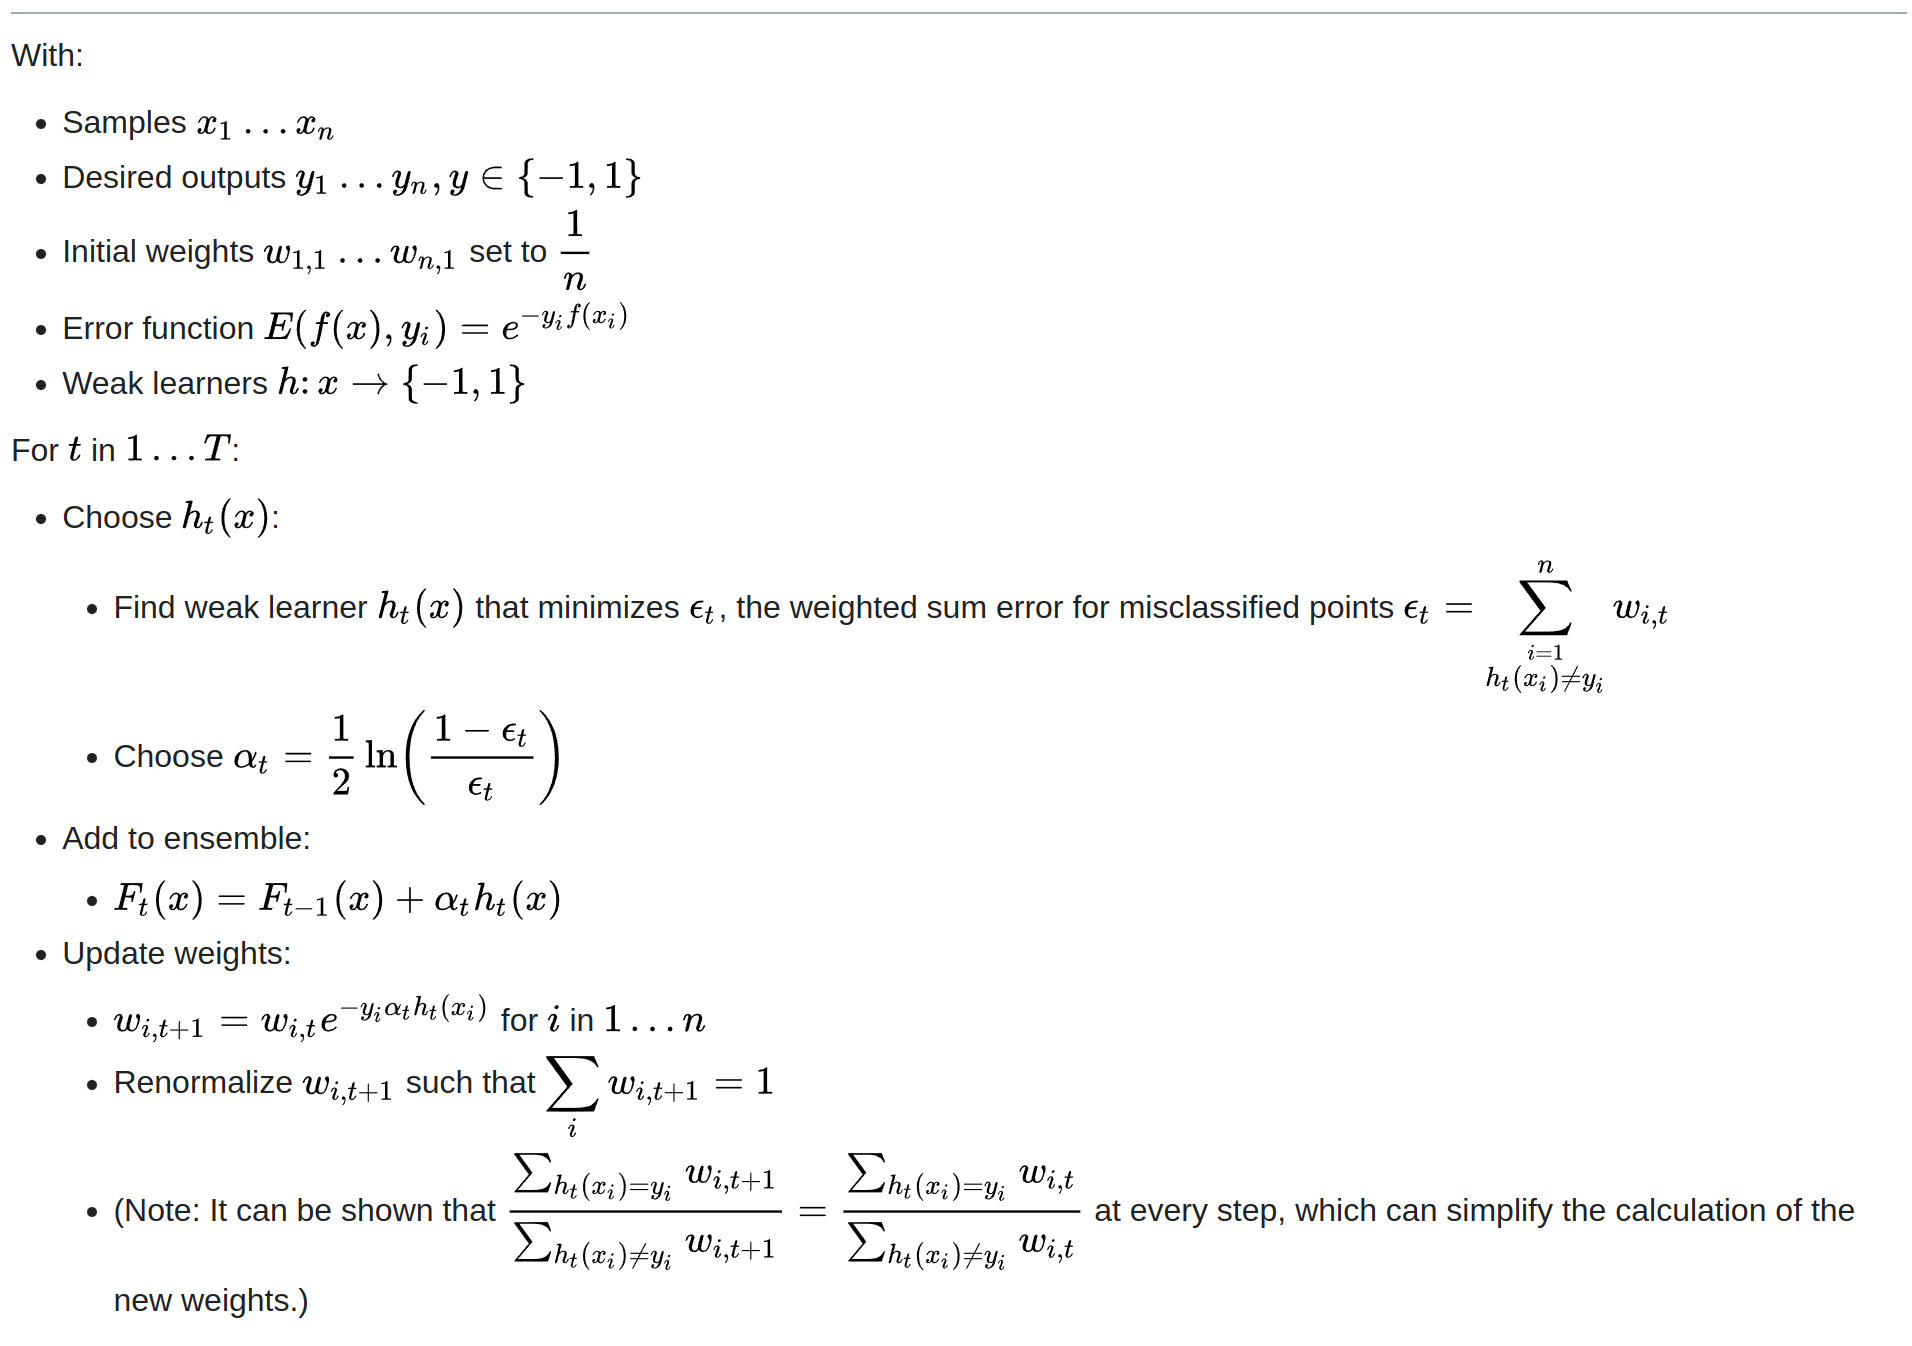

In [4]:
class AdaboostClassifier:

    def __init__(self, base_estimator, n_estimators=50, eta=0.5):

        # Initialising the classifier

        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.eta = eta
        self.ensemble = []
        self.estimator_weights = []

    def fit(self, X, y):

        # Training the ensemble classifier with adaptive boosting

        sample_weights = [1 / len(X)] * len(X)

        for t in range(self.n_estimators):
            model = clone(self.base_estimator)
            model.fit(X, y, sample_weight=sample_weights)
            self.ensemble.append(model)
            y_pred = model.predict(X)
            error = np.sum(sample_weights * (y_pred != y))
            estimator_weight = 0.5 * np.log((1 - error) / error)
            self.estimator_weights.append(estimator_weight)
            sample_weights = sample_weights * np.exp(-self.eta * estimator_weight * y * y_pred)
            sample_weights = sample_weights / np.sum(sample_weights)

    def predict(self, X):

        # Making a weighted prediction using the estimators in the ensemble

        y_pred = np.zeros(len(X))
        for model, estimator_weight in zip(self.ensemble, self.estimator_weights):
            y_pred += estimator_weight * model.predict(X)
        y_pred = np.sign(y_pred)
        return y_pred

    def score(self, X, y):

        # Defining the accuracy score

        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def visualize_boundary(self, X, y):

        # Plotting the decision boundaries of the individual estimators and the ensemble

        fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

        X1, X2 = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max()),
                             np.linspace(X[:, 1].min(), X[:, 1].max()))
        grid = np.vstack([X1.ravel(), X2.ravel()]).T
        y_pred = self.predict(grid).reshape(X1.shape)
        ax[1].contourf(X1, X2, y_pred, alpha=0.3, cmap=colors.ListedColormap(['blue', 'red']))
        ax[1].scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(['blue', 'red']), edgecolors='k')
        ax[1].axis('equal')
        ax[1].set_xlabel('X1')
        ax[1].set_ylabel('X2')
        ax[1].set_title('Ensemble')

        for i, estimator in enumerate(self.ensemble):
            ax[0].contour(X1, X2, estimator.predict(grid).reshape(X1.shape),
                          cmap=colors.ListedColormap(['black', 'black']), levels=[0])
            ax[0].scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(['blue', 'red']), edgecolors='k')
        ax[0].axis('equal')
        ax[0].set_xlabel('X1')
        ax[0].set_ylabel('X2')
        ax[0].set_title(f'Individual Estimators')

        plt.setp(ax, xlim=(X[:, 0].min(), X[:, 0].max()), ylim=(X[:, 1].min(), X[:, 1].max()))
        plt.suptitle(f'{self.base_estimator}\n n_estimators = {self.n_estimators}, η={self.eta}')
        plt.tight_layout()
        plt.show()

# Task 2

We test the ensemble classifier using different base estimators.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

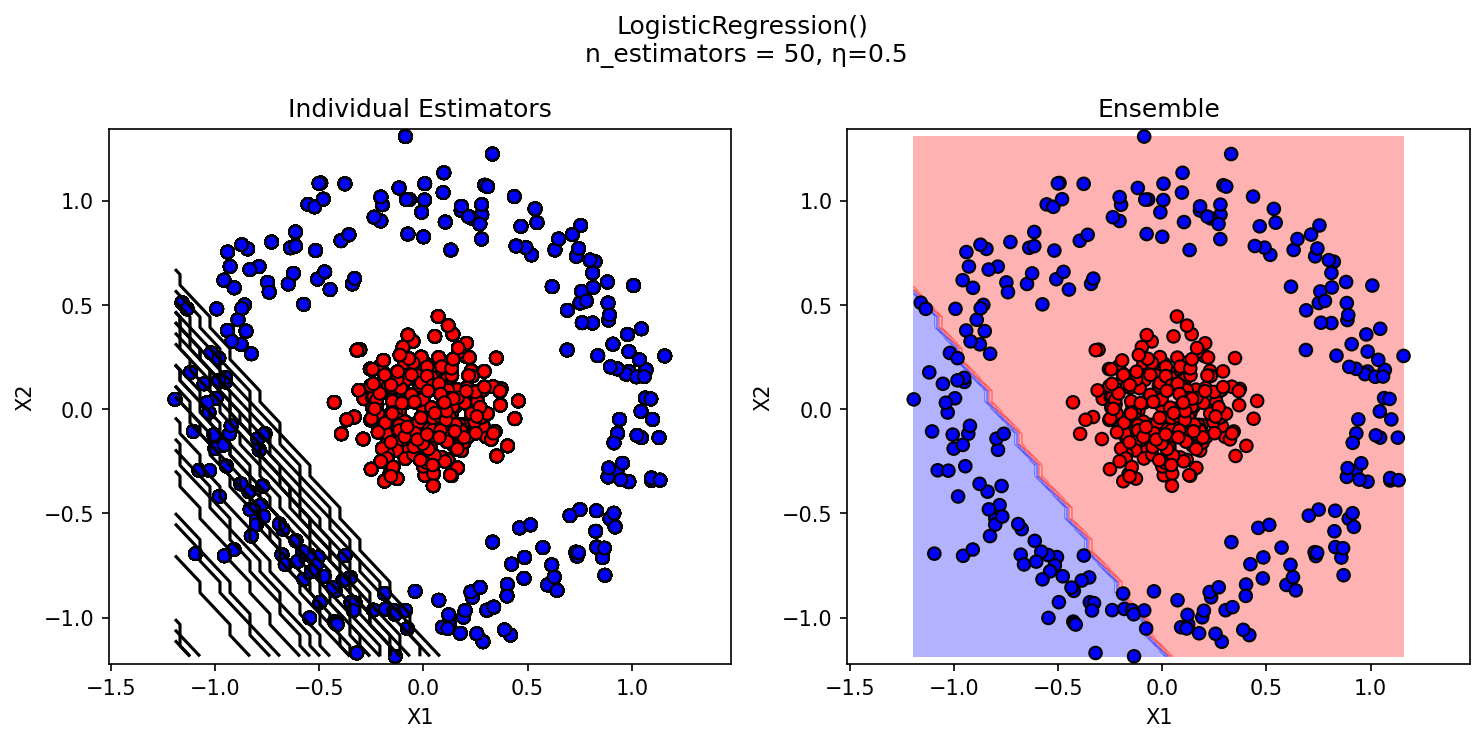

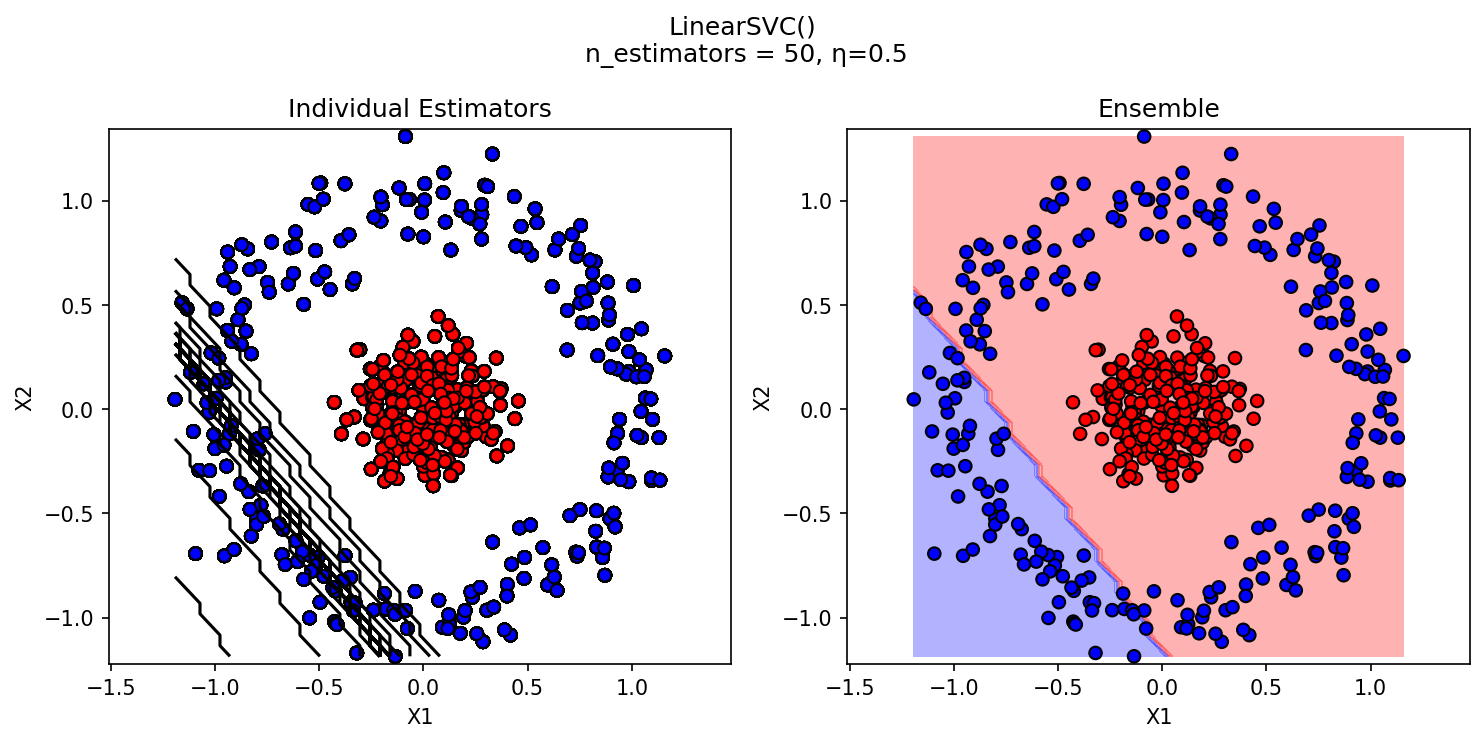

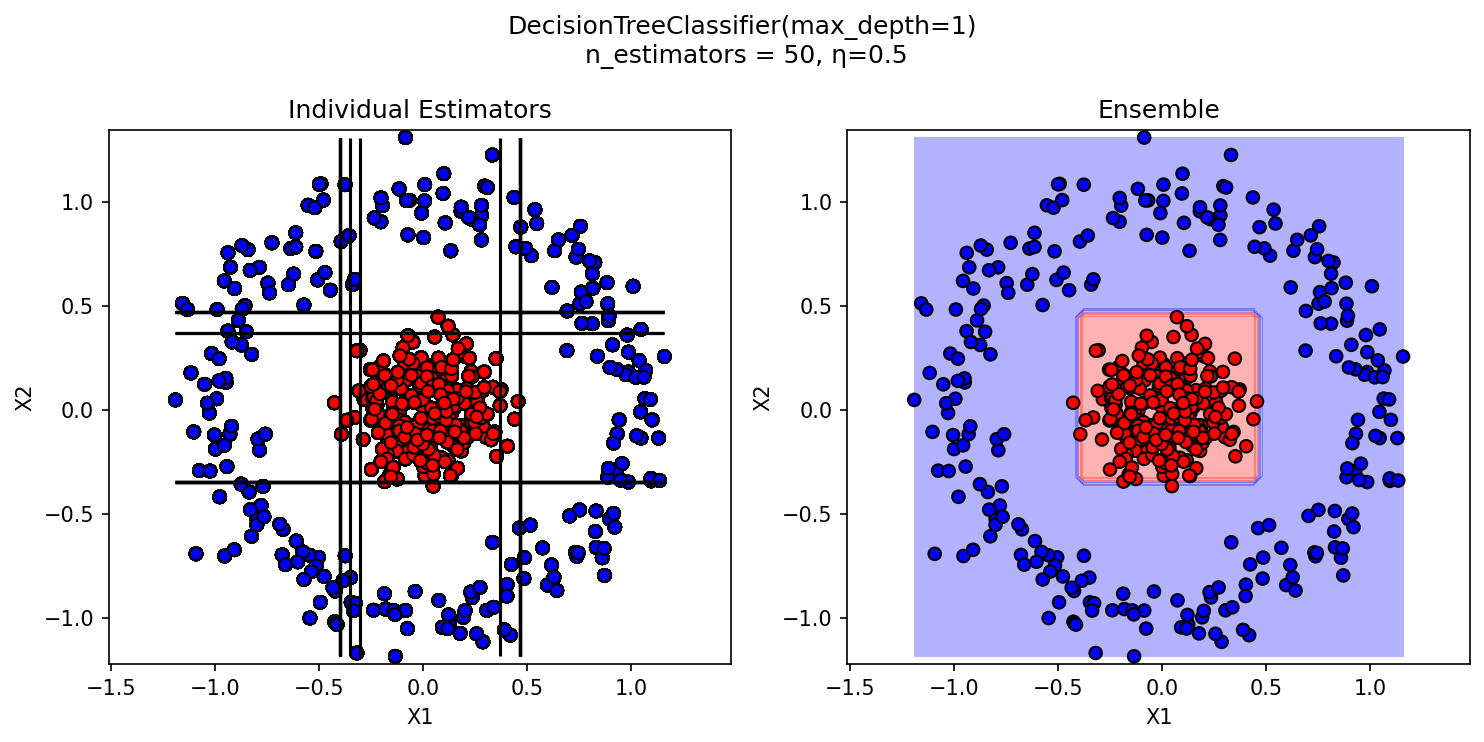

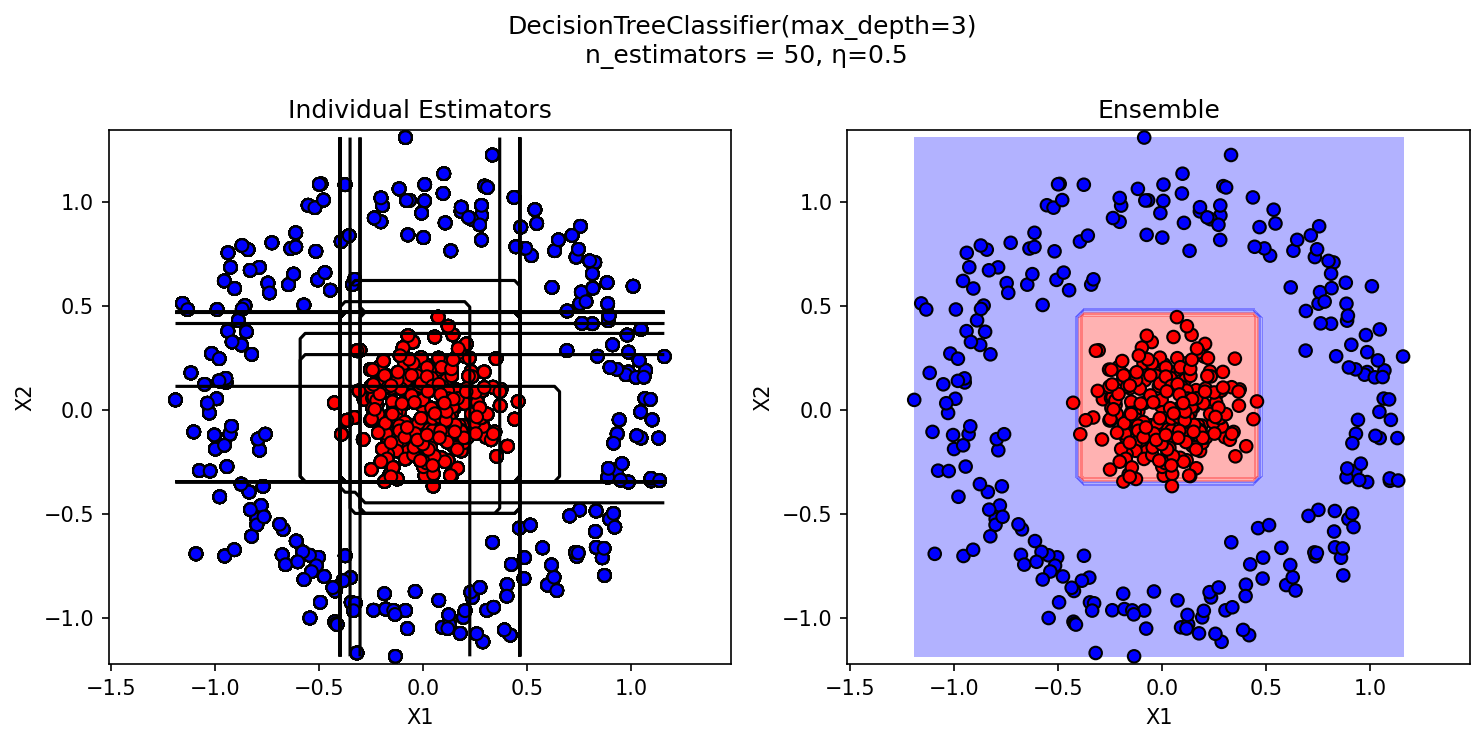

In [6]:
for base_model in [LogisticRegression(), LinearSVC(), DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]:
    adaboost_model = AdaboostClassifier(base_model)
    adaboost_model.fit(X_train, y_train)
    adaboost_model.visualize_boundary(X, y)

We can see that the decision boundaries are different for different estimators. `LogisticRegression` and `LinearSVC` don't seem to be performing well. This can be seen by computing their baseline accuracy scores.

In [7]:
for base_model in [LogisticRegression(), LinearSVC(), DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]:
    base_model.fit(X_train, y_train)
    print(f'Training accuracy of {base_model}: {base_model.score(X_train, y_train):.3f}')
    print(f'Test accuracy of {base_model}: {base_model.score(X_test, y_test):.3f}')
    print()

Training accuracy of LogisticRegression(): 0.328
Test accuracy of LogisticRegression(): 0.264

Training accuracy of LinearSVC(): 0.331
Test accuracy of LinearSVC(): 0.264

Training accuracy of DecisionTreeClassifier(max_depth=1): 0.693
Test accuracy of DecisionTreeClassifier(max_depth=1): 0.712

Training accuracy of DecisionTreeClassifier(max_depth=3): 0.939
Test accuracy of DecisionTreeClassifier(max_depth=3): 0.912



As `DecisionTreeClassifier(max_depth=3)` has the best baseline performance, we will take it forward for hyperparameter tuning.

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
# Defining the hyperparameter grid

tree_param_grid = {'criterion': ['gini', 'entropy'],
                   'min_samples_split': [2, 5, 10, 15, 20],
                   'min_samples_leaf': [1, 2, 4],
                   'max_leaf_nodes': [None, 10, 20, 30, 50],
                   'min_impurity_decrease': [0.0, 0.01, 0.1]}

In [10]:
# Finding the best hyperparameters

grid_model = GridSearchCV(DecisionTreeClassifier(max_depth=3), tree_param_grid, cv=5)
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=3),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_leaf_nodes': [None, 10, 20, 30, 50],
                         'min_impurity_decrease': [0.0, 0.01, 0.1],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10, 15, 20]})

In [11]:
grid_model.best_params_

{'criterion': 'gini',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [12]:
best_base_model = DecisionTreeClassifier(max_depth=3,**grid_model.best_params_)
best_base_model.fit(X_train,y_train)
print(f'Training accuracy of {best_base_model}: {best_base_model.score(X_train, y_train):.3f}')
print(f'Test accuracy of {best_base_model}: {best_base_model.score(X_test, y_test):.3f}')

Training accuracy of DecisionTreeClassifier(max_depth=3, min_samples_split=10): 0.936
Test accuracy of DecisionTreeClassifier(max_depth=3, min_samples_split=10): 0.912


This has a similar performance to the estimator without any tuning. We will take this optimized estimator and ensemble it with adaptive boosting.

In [13]:
base_estimator = DecisionTreeClassifier(**best_base_model.get_params())
adaboost_model = AdaboostClassifier(base_estimator=base_estimator)
adaboost_model.fit(X_train, y_train)
print(f'Training accuracy of AdaBoost: {adaboost_model.score(X_train, y_train):.3f}')
print(f'Test accuracy of AdaBoost: {adaboost_model.score(X_test, y_test):.3f}')

Training accuracy of AdaBoost: 1.000
Test accuracy of AdaBoost: 0.992


This has achieved nearly $100$% accuracy. We will then fine-tune the number of estimators in the ensemble and the hyperparameter $\eta$.

In [14]:
# Fine-tuning the AdaBoost hyperparameters

num_estimators = [5, 10, 25, 50, 100, 200, 500]
eta = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
train_scores = dict()
test_scores = dict()

for n in num_estimators:
    for e in eta:
        base_estimator = clone(DecisionTreeClassifier(**best_base_model.get_params()))
        adaboost_model = AdaboostClassifier(base_estimator=base_estimator, n_estimators=n, eta=e)
        adaboost_model.fit(X_train, y_train)
        train_scores[(n, e)] = adaboost_model.score(X_train, y_train)
        test_scores[(n, e)] = adaboost_model.score(X_test, y_test)

best_n_estimators = max(test_scores, key=lambda x: test_scores[x])[0]
best_eta = max(test_scores, key=lambda x: test_scores[x])[1]

print(f'Best training accuracy: {train_scores[(best_n_estimators,best_eta)]:.3f}')
print(f'Best test accuracy: {max(test_scores.values()):.3f}')
print(f'Best n_estimators: {best_n_estimators}')
print(f'Best eta: {best_eta}')

Best training accuracy: 1.000
Best test accuracy: 1.000
Best n_estimators: 5
Best eta: 0.25


We see that when $5$ estimators are used with $\eta=0.25$, we get $100$% accuracy on both the train and test sets. We can plot the decision boundary for this ensemble.

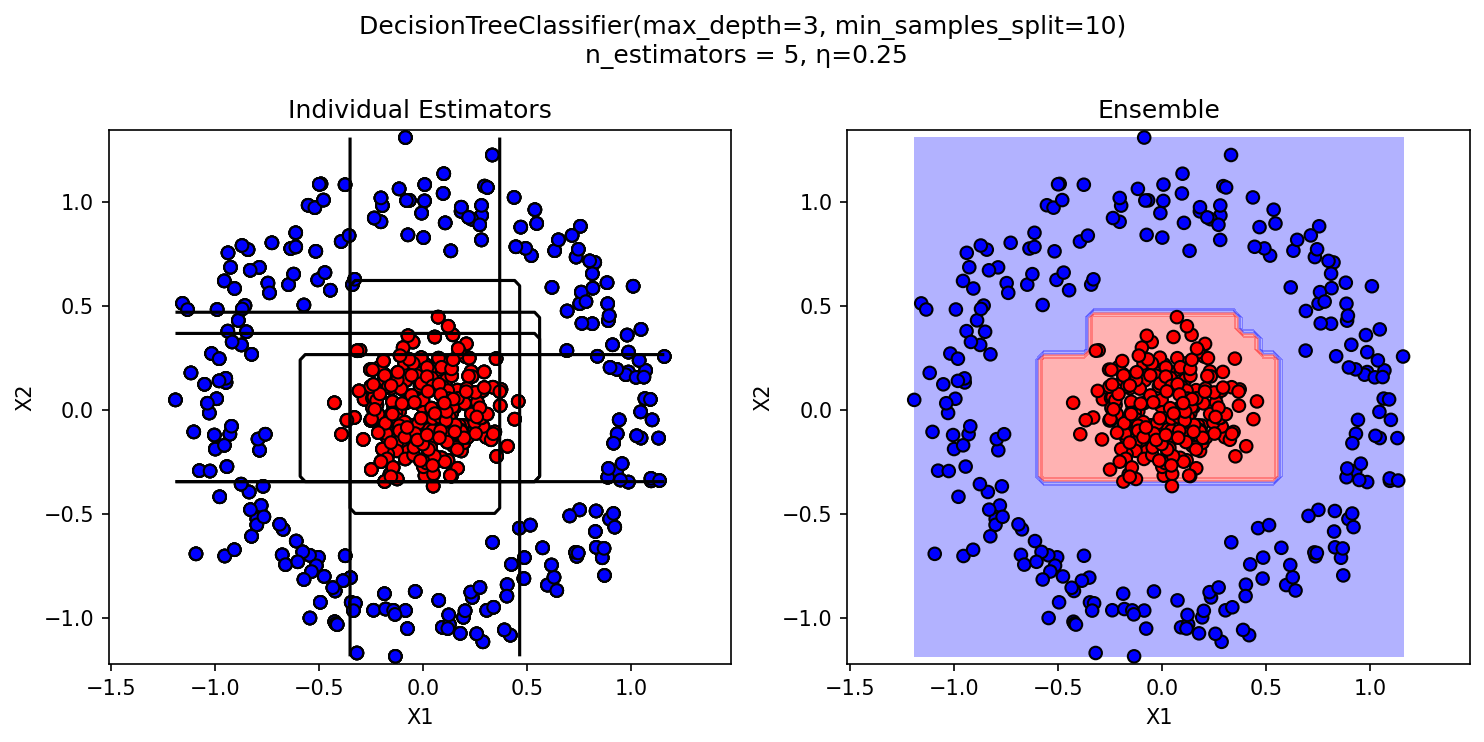

In [15]:
best_adaboost_model = AdaboostClassifier(base_estimator=base_estimator, n_estimators=best_n_estimators, eta=best_eta)
best_adaboost_model.fit(X_train, y_train)
best_adaboost_model.visualize_boundary(X, y)

We can observe that this ensemble classifier performs extremely well on the dataset. The decision boundary is more complex than when $50$ estimators were used with $\eta=0.5$.